# **Import Necessary Dependencies and Libraries**

In [1]:
!pip install opendatasets

In [2]:
# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import alexnet
from torchvision.models import VGG11_BN_Weights

import opendatasets as od
# Data handling libraries
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import copy

# Scikit-learn libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, ParameterGrid

# System and utilities
import sys
sys.path.append("path")
import warnings
warnings.filterwarnings("ignore")
import pickle

# File and folder manipulation
import os
import cv2
import shutil
import random
from IPython.display import FileLink

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image
import seaborn as sns
import plotly.express as px

# Time tracking
import time

# **Data Importing & Exploration**

## **Load Data**

In [3]:
#download dataset
od.download("https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sleekyucee
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset


100%|██████████| 38.4M/38.4M [00:00<00:00, 111MB/s]


In [4]:
#check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device:",device)

Device: cuda


In [5]:
#define data directory and subdirectories
data_dir = "/content/animal-image-classification-dataset"
animals_dir = os.path.join(data_dir, "Animals")
cats_dir = os.path.join(animals_dir, "cats")
snakes_dir = os.path.join(animals_dir, "snakes")
dogs_dir = os.path.join(animals_dir, "dogs")

In [6]:
#define train, validation, and test directory paths
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

#create sub directories for each animal type within train_dir, val_dir, and test_dir
for animal_type in ["cats", "snakes", "dogs"]:
    os.makedirs(os.path.join(train_dir, animal_type), exist_ok=True)
    os.makedirs(os.path.join(val_dir, animal_type), exist_ok=True)
    os.makedirs(os.path.join(test_dir, animal_type), exist_ok=True)

## **Explore Data**

In [7]:
#get the number of samples for each class
num_cats = len(os.listdir(cats_dir))
num_snakes = len(os.listdir(snakes_dir))
num_dogs = len(os.listdir(dogs_dir))

In [8]:
#display number of samples in each class
print(f"Number of samples in cats directory: {num_cats}")
print(f"\nNumber of samples in snakes directory: {num_snakes}")
print(f"\nNumber of samples in dogs directory: {num_dogs}")

#display total number of samples
total_samples = num_cats + num_snakes + num_dogs
print(f"\nTotal number of samples: {total_samples}")

Number of samples in cats directory: 1000

Number of samples in snakes directory: 1000

Number of samples in dogs directory: 1000

Total number of samples: 3000


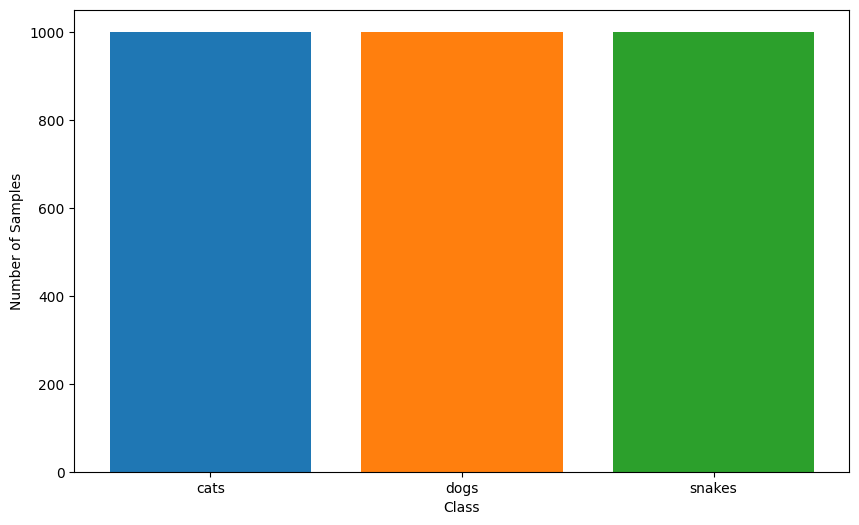

In [9]:
#bar plot to visualize number of samples
class_labels = ["cats", "dogs", "snakes"]
class_counts = [num_cats, num_dogs, num_snakes]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts, color=colors)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

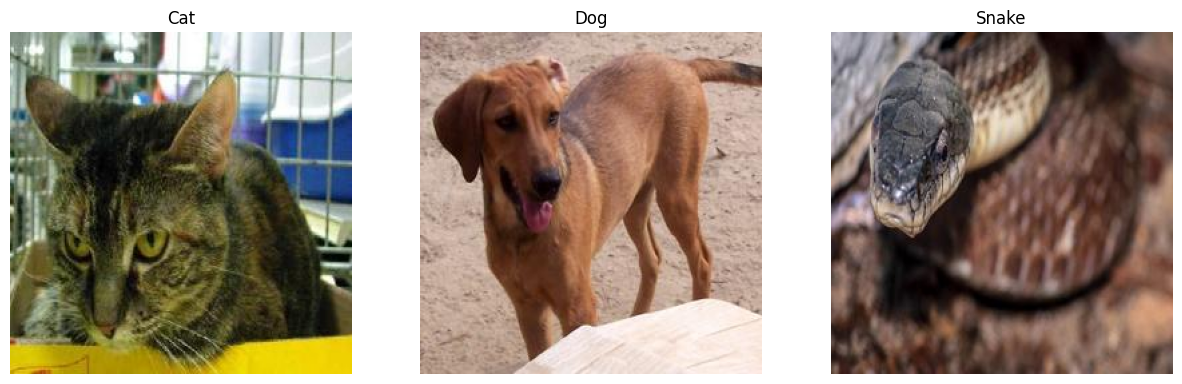

In [10]:
#display sample images of the classes of animal
sample_cat = os.path.join(cats_dir, os.listdir(cats_dir)[0])
sample_dog = os.path.join(dogs_dir, os.listdir(dogs_dir)[0])
sample_snake = os.path.join(snakes_dir, os.listdir(snakes_dir)[0])

#open and display the immages
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Image.open(sample_cat))
axs[0].set_title("Cat")
axs[0].axis("off")
axs[1].imshow(Image.open(sample_dog))
axs[1].set_title("Dog")
axs[1].axis("off")
axs[2].imshow(Image.open(sample_snake))
axs[2].set_title("Snake")
axs[2].axis("off")
plt.show()

In [11]:
#check random image shape
img1 = cv2.imread(sample_cat)
img2 = cv2.imread(sample_dog)
img3 = cv2.imread(sample_snake)
display(img1.shape, img2.shape, img3.shape)

(256, 256, 3)

(256, 256, 3)

(256, 256, 3)

## **Split Data**

In [12]:
#define split ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

In [13]:
#define a function to split data into train_dir, val_dir, test_dir
def split_data(src_dir, train_dir, val_dir, test_dir, train_ratio, val_ratio, test_ratio):
    files = os.listdir(src_dir)
    random.shuffle(files)
    total_files = len(files)

    train_split = int(total_files * train_ratio)
    val_split = int(total_files * val_ratio)
    test_split = int(total_files * test_ratio)

    train_files = files[:train_split]
    val_files = files[train_split:(train_split + val_split)]
    test_files = files[(train_split + val_split):]

    for file in train_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(train_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    for file in val_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(val_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

    for file in test_files:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(test_dir, file)
        if os.path.isfile(src_path):
            shutil.copy(src_path, dst_path)

In [14]:
#split data
split_data(cats_dir,
           os.path.join(train_dir, "cats"),
           os.path.join(val_dir, "cats"),
           os.path.join(test_dir, "cats"),
           train_ratio,
           val_ratio,
           test_ratio
)

split_data(dogs_dir,
           os.path.join(train_dir, "dogs"),
           os.path.join(val_dir, "dogs"),
           os.path.join(test_dir, "dogs"),
           train_ratio,
           val_ratio,
           test_ratio
)

split_data(snakes_dir,
           os.path.join(train_dir, "snakes"),
           os.path.join(val_dir, "snakes"),
           os.path.join(test_dir, "snakes"),
           train_ratio,
           val_ratio,
           test_ratio
)

In [15]:
#count samples in each class and directory after splitting
train_cats = len(os.listdir(os.path.join(train_dir, "cats")))
train_dogs = len(os.listdir(os.path.join(train_dir, "dogs")))
train_snakes = len(os.listdir(os.path.join(train_dir, "snakes")))

val_cats = len(os.listdir(os.path.join(val_dir, "cats")))
val_dogs = len(os.listdir(os.path.join(val_dir, "dogs")))
val_snakes = len(os.listdir(os.path.join(val_dir, "snakes")))

test_cats = len(os.listdir(os.path.join(test_dir, "cats")))
test_dogs = len(os.listdir(os.path.join(test_dir, "dogs")))
test_snakes = len(os.listdir(os.path.join(test_dir, "snakes")))

#total samples in each class
cats_total = train_cats + val_cats + test_cats
dogs_total = train_dogs + val_dogs + test_dogs
snakes_total = train_snakes + val_snakes + test_snakes

#total train, val, and test samples
train_total = train_cats + train_dogs + train_snakes
val_total = val_cats + val_dogs + val_snakes
test_total = test_cats + test_dogs + test_snakes

#total samples in entire dataset
total_samples = cats_total + dogs_total + snakes_total

#display counts
print(f"Cats - \nTrain: {train_cats}, \nVal: {val_cats}, \nTest: {test_cats}, \nTotal: {cats_total}")
print(f"\nDogs - \nTrain: {train_dogs}, \nVal: {val_dogs}, \nTest: {test_dogs}, \nTotal: {dogs_total}")
print(f"\nSnakes - \nTrain: {train_snakes}, \nVal: {val_snakes}, \nTest: {test_snakes}, \nTotal: {snakes_total}")
print(f"\nTotal Train: {train_total}, \nTotal Val: {val_total}, \nTotal Test: {test_total}, \nTotal Data: {total_samples}")

Cats - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Dogs - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Snakes - 
Train: 700, 
Val: 100, 
Test: 200, 
Total: 1000

Total Train: 2100, 
Total Val: 300, 
Total Test: 600, 
Total Data: 3000


## **Create DataFrames**

In [16]:
#initialize dict to store df of split data(train, val, test)
data_dict = {"train": None, "val": None, "test": None}

#loop through each split
for split, split_dir in [("train", train_dir), ("val", val_dir), ("test", test_dir)]:
    #initialize empty list to store data
    data = []

    for animal_type in ["cats", "dogs", "snakes"]:
        animal_dir = os.path.join(split_dir, animal_type)
        for image_name in os.listdir(animal_dir):
            data.append(
                {
                    "Label": animal_type,
                    "Image_Name": image_name,
                }
            )

    #create df from data
    data_dict[split] = pd.DataFrame(data)

#retrieve dataframes
train_df = data_dict["train"]
val_df = data_dict["val"]
test_df = data_dict["test"]

In [17]:
#display 5 random rows of train df, val df, and test df
display(train_df.sample(5), val_df.sample(5), test_df.sample(5))

,Label,Image_Name
84,cats,0_0203.jpg
1249,dogs,1_0328.jpg
502,cats,0_0366.jpg
1915,snakes,2_0910.jpg
1603,snakes,2_0163.jpg


,Label,Image_Name
235,snakes,2_0124.jpg
74,cats,0_0519.jpg
269,snakes,2_0220.jpg
63,cats,0_0294.jpg
209,snakes,2_1000.jpg


,Label,Image_Name
104,cats,0_0653.jpg
470,snakes,2_0918.jpg
165,cats,0_0049.jpg
245,dogs,1_0960.jpg
468,snakes,2_0436.jpg


## **Labels to Numeric**

In [18]:
#retrieve class names from labels and map classes to numbers
for df in [train_df, val_df, test_df]:
    class_names = df["Label"].unique()
    class_to_num = {class_name: i for i, class_name in enumerate(class_names)}
    df["Label"] = df["Label"].map(class_to_num)

In [19]:
#view changes
display(train_df.sample(5), val_df.sample(5), test_df.sample(5))

,Label,Image_Name
406,0,0_0066.jpg
1992,2,2_0325.jpg
469,0,0_0581.jpg
1120,1,1_0843.jpg
1931,2,2_0121.jpg


,Label,Image_Name
81,0,0_0637.jpg
279,2,2_0925.jpg
60,0,0_0250.jpg
47,0,0_0286.jpg
200,2,2_0646.jpg


,Label,Image_Name
408,2,2_0710.jpg
255,1,1_0166.jpg
565,2,2_0507.jpg
364,1,1_0765.jpg
191,0,0_0204.jpg


In [20]:
#save train, val, and test data as csv files
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

## **Data Transformations**

**Transforms 1**

In [21]:
#define data transformations for train set
train_transforms = transforms.Compose(
    [
        transforms.RandomRotation(20),
        transforms.Resize((356, 356)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

#define data transformations for val and test data
val_test_transforms = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.CenterCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

**Transforms 2**

In [30]:
#define data transformations for train set
train_transforms2 = transforms.Compose(
    [
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

#define data transformations for val and test data
val_test_transforms2 = transforms.Compose(
    [
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## **Create Dataset**

In [22]:
class CatsDogsAndSnakes(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = ['cats', 'dogs', 'snakes']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_index = self.data.iloc[idx, 0]
        animal_type = self.class_names[label_index]
        img_name = os.path.join(self.root_dir,
                                animal_type,
                                self.data.iloc[idx, 1])
        image = Image.open(img_name)
        label = self.data.iloc[idx, 0]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

**Dataset 1**

In [23]:
#train dataset
train_dataset = CatsDogsAndSnakes(csv_file="train.csv", root_dir=train_dir, transform=train_transforms)

#val dataset
val_dataset = CatsDogsAndSnakes(csv_file="val.csv", root_dir=val_dir, transform=val_test_transforms)

#test dataset
test_dataset = CatsDogsAndSnakes(csv_file="test.csv", root_dir=test_dir, transform=val_test_transforms)

**Dataset 2**

In [31]:
#train dataset
train_dataset2 = CatsDogsAndSnakes(csv_file="train.csv", root_dir=train_dir, transform=train_transforms2)

#val dataset
val_dataset2 = CatsDogsAndSnakes(csv_file="val.csv", root_dir=val_dir, transform=val_test_transforms2)

#test dataset
test_dataset2 = CatsDogsAndSnakes(csv_file="test.csv", root_dir=test_dir, transform=val_test_transforms2)

In [24]:
#check shape of first samples
assert train_dataset[0][0].shape == val_dataset[0][0].shape == test_dataset[0][0].shape

In [25]:
#display shapes
print(f"Train: {train_dataset[0][0].shape}")
print(f"Val: {val_dataset[0][0].shape}")
print(f"Test: {test_dataset[0][0].shape}")

Train: torch.Size([3, 299, 299])
Val: torch.Size([3, 299, 299])
Test: torch.Size([3, 299, 299])


## **Create DataLoaders**

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20
batch_size = 32
shuffleT = True
shuffleF = False

**DataLoader 1**

In [29]:
#train dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffleT)

#val dataloader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffleF)

#test dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffleF)

**DataLoader 2**

In [32]:
#train dataloader
train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=shuffleT)

#val dataloader
val_loader2 = DataLoader(val_dataset2, batch_size=batch_size, shuffle=shuffleF)

#test dataloader
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=shuffleF)

# **Models Development**

## **Model Summary Class**

In [35]:
class ModelSummary:
    def __init__(self, model):
        self.model = model

    def __str__(self):
        model_summary = str(self.model) + "\n\n"
        total_trainable_params = 0
        total_frozen_params = 0

        for name, parameter in self.model.named_parameters():
            if parameter.requires_grad:
                total_trainable_params += parameter.numel()
                status = "Trainable"
            else:
                total_frozen_params += parameter.numel()
                status = "Frozen"

            model_summary += f"Layer: {name}, Parameters: {parameter.numel()}, Status: {status}\n"

        model_summary += f"Total Trainable Parameters: {total_trainable_params}\n"
        model_summary += f"Total Frozen Parameters: {total_frozen_params}"

        return model_summary

## **Model Train Class**

In [36]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion=None, optimizer=None, device="cuda", num_epochs=100, patience=5, min_delta=0.001, model_name=None, verbose=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.device = device
        self.num_epochs = num_epochs
        self.patience = patience
        self.min_delta = min_delta
        self.model_name = model_name
        self.verbose = verbose
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []


    def train(self, verbose=False):
            best_val_loss = float('inf')
            early_stopping_counter = 0
            start_time = time.time()

            for epoch in range(self.num_epochs):
                total_correct = 0
                total_samples = 0
                total_loss = 0.0

                if self.verbose:
                    train_data_loader = tqdm(self.train_loader, position=0)
                else:
                    train_data_loader = self.train_loader

                for batch_idx, (inputs, labels) in enumerate(train_data_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()

                    _, predicted = outputs.max(1)
                    total_samples += labels.size(0)
                    total_correct += (predicted == labels).sum().item()
                    total_loss += loss.item()

                    train_accuracy = total_correct / total_samples
                    train_loss = total_loss / total_samples
                    self.train_acc_history.append(train_accuracy)
                    self.train_loss_history.append(train_loss)

                    if self.verbose:
                        description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(train_data_loader)}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%'
                        train_data_loader.set_description(description, refresh=True)

                if self.verbose:
                    train_data_loader.close()

                total_correct_val = 0
                total_samples_val = 0
                total_loss_val = 0.0

                # Validation phase
                self.model.eval()


                with torch.no_grad():
                    if self.verbose:
                        val_data_loader = tqdm(self.val_loader, position=0)
                    else:
                        val_data_loader = self.val_loader

                    for batch_idx, (inputs, labels) in enumerate(val_data_loader):
                        inputs, labels = inputs.to(self.device), labels.to(self.device)
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, labels)
                        total_loss_val += loss.item()

                        _, predicted = outputs.max(1)
                        total_samples_val += labels.size(0)
                        total_correct_val += (predicted == labels).sum().item()

                        val_accuracy = total_correct_val / total_samples_val
                        val_loss = total_loss_val / total_samples_val
                        self.val_acc_history.append(val_accuracy)
                        self.val_loss_history.append(val_loss)

                        if self.verbose:
                            description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(val_data_loader)}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%'
                            val_data_loader.set_description(description, refresh=True)

                    if self.verbose:
                        val_data_loader.close()

                if val_loss < best_val_loss - self.min_delta:
                    best_val_loss = val_loss
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1


                if early_stopping_counter >= self.patience:
                    print("Early stopping triggered. No improvement for {} epochs.".format(self.patience))
                    break

            print("\nTraining completed!")
            end_time = time.time()
            training_time = end_time - start_time
            print(f"Training took {self.format_time(training_time)}\n")

            # Save model
            model_save_path = f'{self.model_name}.pth'
            self.save_model(model_save_path)
            print(f"Model saved at {model_save_path}")




    def train_one_epoch(self, epoch, verbose=None):
        self.model.train()
        if verbose is not None:
            self.verbose = verbose

        total_correct = 0
        total_samples = 0
        total_loss = 0.0

        #training phase
        if self.verbose:
            train_data_loader = tqdm(self.train_loader, position=0)
        else:
            train_data_loader = self.train_loader

        for batch_idx, (inputs, labels) in enumerate(train_data_loader):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            train_accuracy = total_correct / total_samples
            train_loss = total_loss / total_samples
            self.train_acc_history.append(train_accuracy)
            self.train_loss_history.append(train_loss)

            if self.verbose:
                description = f'Epoch [{epoch + 1}/{self.num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%'
                train_data_loader.set_description(description, refresh=True)

        if self.verbose:
            train_data_loader.close()

        total_correct_val = 0
        total_samples_val = 0
        total_loss_val = 0.0

        #validation phase
        if self.verbose:
            val_data_loader = self.val_loader
        else:
            val_data_loader = self.val_loader

        #set model to evaluation mode
        self.model.eval()

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_data_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                total_loss_val += loss.item()

                _, predicted = outputs.max(1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()

            val_accuracy = total_correct_val / total_samples_val
            val_loss = total_loss_val / total_samples_val
            self.val_acc_history.append(val_accuracy)
            self.val_loss_history.append(val_loss)

            if self.verbose:
                description = f'Epoch [{epoch + 1}/{self.num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%'
                print(description)

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)

    def format_time(self, seconds):
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)
        return f"{int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds"

In [37]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion=None, optimizer=None, device="cuda", num_epochs=100, patience=5, min_delta=0.001, model_name=None, verbose=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.device = device
        self.num_epochs = num_epochs
        self.patience = patience
        self.min_delta = min_delta
        self.model_name = model_name
        self.verbose = verbose
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_loss_history = []
        self.val_loss_history = []

    def train(self, verbose=False):
        best_val_loss = float('inf')
        early_stopping_counter = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            total_correct = 0
            total_samples = 0
            total_loss = 0.0

            if self.verbose:
                train_data_loader = tqdm(self.train_loader, position=0)
            else:
                train_data_loader = self.train_loader

            for batch_idx, (inputs, labels) in enumerate(train_data_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()
                total_loss += loss.item()

                train_accuracy = total_correct / total_samples
                train_loss = total_loss / total_samples
                self.train_acc_history.append(train_accuracy)
                self.train_loss_history.append(train_loss)

                if self.verbose:
                    description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(train_data_loader)}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy * 100:.2f}%'
                    train_data_loader.set_description(description, refresh=True)

            if self.verbose:
                train_data_loader.close()

            total_correct_val = 0
            total_samples_val = 0
            total_loss_val = 0.0

            # Validation phase
            self.model.eval()

            with torch.no_grad():
                if self.verbose:
                    val_data_loader = tqdm(self.val_loader, position=0)
                else:
                    val_data_loader = self.val_loader

                for batch_idx, (inputs, labels) in enumerate(val_data_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    total_loss_val += loss.item()

                    _, predicted = outputs.max(1)
                    total_samples_val += labels.size(0)
                    total_correct_val += (predicted == labels).sum().item()

                    val_accuracy = total_correct_val / total_samples_val
                    val_loss = total_loss_val / total_samples_val
                    self.val_acc_history.append(val_accuracy)
                    self.val_loss_history.append(val_loss)

                    if self.verbose:
                        description = f'Epoch [{epoch + 1}/{self.num_epochs}], Batch [{batch_idx + 1}/{len(val_data_loader)}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%'
                        val_data_loader.set_description(description, refresh=True)

                if self.verbose:
                    val_data_loader.close()

            if val_loss < best_val_loss - self.min_delta:
                best_val_loss = val_loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= self.patience:
                print("Early stopping triggered. No improvement for {} epochs.".format(self.patience))
                break

        print("\nTraining completed!")
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training took {self.format_time(training_time)}\n")

        # Save model
        model_save_path = f'{self.model_name}.pth'
        self.save_model(model_save_path)
        print(f"Model saved at {model_save_path}")

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)

    def format_time(self, seconds):
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)
        return f"{int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds"

## **Model Training Curve Class**

In [38]:
class TrainCurvePlotter:
    def __init__(self, train_history_file):
        self.train_history_file = train_history_file
        self.train_loss = None
        self.train_acc = None
        self.val_loss = None
        self.val_acc = None
        self.num_epochs = None

    def load_training_history(self):
        with open(self.train_history_file, 'rb') as file:
            history = pickle.load(file)
            self.train_loss = history['train_loss_history']
            self.train_acc = history['train_acc_history']
            self.val_loss = history['val_loss_history']
            self.val_acc = history['val_acc_history']
            train_batches_per_epoch = len(self.train_loss) // len(self.val_loss)

            self.num_epochs = len(self.val_loss)

    def plot(self):
        #load the training history data
        self.load_training_history()

        train_batches_per_epoch = len(self.train_loss) // len(self.val_loss)

        #calculate mean loss and accuracy values per epoch
        train_losses = [np.mean(self.train_loss[i:i+train_batches_per_epoch]) for i in range(0, len(self.train_loss), train_batches_per_epoch)]
        train_accuracies = [np.mean(self.train_acc[i:i+train_batches_per_epoch]) for i in range(0, len(self.train_acc), train_batches_per_epoch)]
        val_losses = self.val_loss
        val_accuracies = self.val_acc

        #align lengths
        min_len = min(len(train_losses), len(val_losses))
        train_losses = train_losses[:min_len]
        train_accuracies = train_accuracies[:min_len]
        val_losses = val_losses[:min_len]
        val_accuracies = val_accuracies[:min_len]

        #create an epoch range based on the number of epochs
        epochs = range(1, self.num_epochs + 1)

        #check len train and val loss are equal
        assert len(train_losses) == len(val_losses)

        #plot training loss and accuracy
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Training Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [40]:
class ModelEvaluator:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def evaluate(self):
        self.model.eval()

        total_correct = 0
        total_samples = 0

        for inputs, labels in self.dataloader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)

            _, predicted = outputs.max(1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples

        return accuracy

## **Model Predictor Class**

In [41]:
class ModelPredictor:
    def __init__(self, model, dataloader, device):
        self.model = model
        self.dataloader = dataloader
        self.device = device

    def predict(self):
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in self.dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                predicted = outputs.argmax(dim=1)

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        predictions = np.array(predictions)
        true_labels = np.array(true_labels)

        return predictions, true_labels


    def plot_predictions(self):
        predictions, true_labels = self.predict()

        # Create a grouped bar chart
        classes = np.unique(true_labels)
        class_labels = [str(cls) for cls in classes]

        width = 0.35
        ind = np.arange(len(classes))

        true_counts = [0] * len(classes)
        predicted_counts = [0] * len(classes)

        for true, pred in zip(true_labels, predictions):
            true_counts[true] += 1
            predicted_counts[pred] += 1

        fig, ax = plt.subplots(figsize=(10, 6))
        p1 = ax.bar(ind - width / 2, true_counts, width, label='True Labels')
        p2 = ax.bar(ind + width / 2, predicted_counts, width, label='Predicted Labels')

        ax.set_xlabel('Classes')
        ax.set_ylabel('Counts')
        ax.set_title('True vs. Predicted Labels')
        ax.set_xticks(ind)
        ax.set_xticklabels(class_labels)
        ax.legend()

        #annotate the bars with counts
        for i in range(len(classes)):
            ax.annotate(str(true_counts[i]), (ind[i] - width / 2, true_counts[i] + 1), ha='center', color='blue')
            ax.annotate(str(predicted_counts[i]), (ind[i] + width / 2, predicted_counts[i] + 1), ha='center', color='orange')

        plt.show()

## **Model Performance Class**

In [42]:
class PerformanceMetrics:
    def __init__(self, true_labels, predicted_labels, class_names):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.class_names = class_names

    def calculate_accuracy(self):
        accuracy = accuracy_score(self.true_labels, self.predicted_labels)
        return accuracy * 100

    def calculate_confusion_matrix(self):
        return confusion_matrix(self.true_labels, self.predicted_labels)

    def calculate_specificity(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_negatives = conf_matrix[0, 0]
        false_positives = conf_matrix[0, 1]
        specificity = true_negatives / (true_negatives + false_positives) * 100
        return specificity

    def calculate_sensitivity(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_positives = conf_matrix[1, 1]
        false_negatives = conf_matrix[1, 0]
        sensitivity = true_positives / (true_positives + false_negatives) * 100
        return sensitivity

    def calculate_precision(self):
        conf_matrix = self.calculate_confusion_matrix()
        true_positives = conf_matrix[1, 1]
        false_positives = conf_matrix[0, 1]
        precision = true_positives / (true_positives + false_positives) * 100
        return precision

    def generate_classification_report(self):
        return classification_report(self.true_labels, self.predicted_labels, target_names=self.class_names)

    def plot_heatmap(self):
        conf_matrix = self.calculate_confusion_matrix()
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix Heatmap')
        plt.show()

## **Model One**

**Build Model**

In [51]:
#model architecture
class AnimalClassifier(nn.Module):
    def __init__(self,
                 num_classes=3,
                 conv1_out_channels=32,
                 conv2_out_channels=64,
                 conv3_out_channels=128):
        super(AnimalClassifier, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3,  #input channels (RGB image)
            out_channels=conv1_out_channels,  #no of output channels
            kernel_size=3,  #size of convolution kernel
            stride=1,  #convolution stride
            padding=1  #padding applied to the input
        )
        self.conv2 = nn.Conv2d(
            in_channels=conv1_out_channels,
            out_channels=conv2_out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=conv2_out_channels,
            out_channels=conv3_out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  #max pooling layer
        self.fc1 = nn.Linear(conv3_out_channels * 37 * 37, 512)  #fully connected layer
        self.fc2 = nn.Linear(512, num_classes)  #output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # flatten the feature maps
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Get Summary**

In [52]:
#model summary
model1 = AnimalClassifier()

#instantiate model summary class
model_summary = ModelSummary(model1)

#display model summary
print(model_summary)

AnimalClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=175232, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

Layer: conv1.weight, Parameters: 864, Status: Trainable
Layer: conv1.bias, Parameters: 32, Status: Trainable
Layer: conv2.weight, Parameters: 18432, Status: Trainable
Layer: conv2.bias, Parameters: 64, Status: Trainable
Layer: conv3.weight, Parameters: 73728, Status: Trainable
Layer: conv3.bias, Parameters: 128, Status: Trainable
Layer: fc1.weight, Parameters: 89718784, Status: Trainable
Layer: fc1.bias, Parameters: 512, Status: Trainable
Layer: fc2.weight, Parameters: 1536, Status: Trainable
Layer: fc2.bias, Parameters: 3, Status: 

**Train Model**

In [44]:
def set_seed(seed=42):
    """Sets the random seed for Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [56]:
#set seed before training
set_seed(seed=36)

#train model one
#initialize model
model1 = AnimalClassifier()

#set parameters
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.0001}

#instantiate optimizer
optimizer_instance = optimizer(model1.parameters(), **optimizer_params)

#instantiate trainer
trainer = Trainer(
    model=model1,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=num_epochs,
    model_name='model1',
    verbose=True
)

#train model
trainer.train()

Epoch [1/20], Batch [66/66], Training Loss: 0.0313, Training Accuracy: 48.95%: 100%|██████████| 66/66 [00:45<00:00,  1.45it/s]
Epoch [1/20], Batch [10/10], Validation Loss: 0.0287, Validation Accuracy: 57.33%: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
Epoch [2/20], Batch [66/66], Training Loss: 0.0262, Training Accuracy: 58.71%: 100%|██████████| 66/66 [00:46<00:00,  1.43it/s]
Epoch [2/20], Batch [10/10], Validation Loss: 0.0257, Validation Accuracy: 62.67%: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]
Epoch [3/20], Batch [66/66], Training Loss: 0.0239, Training Accuracy: 61.57%: 100%|██████████| 66/66 [00:46<00:00,  1.42it/s]
Epoch [3/20], Batch [10/10], Validation Loss: 0.0232, Validation Accuracy: 67.67%: 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]
Epoch [4/20], Batch [66/66], Training Loss: 0.0232, Training Accuracy: 66.48%: 100%|██████████| 66/66 [00:45<00:00,  1.45it/s]
Epoch [4/20], Batch [10/10], Validation Loss: 0.0223, Validation Accuracy: 66.00%: 100%|██████████|

Early stopping triggered. No improvement for 5 epochs.

Training completed!
Training took 0 hours, 11 minutes, 54 seconds

Model saved at model1.pth


In [47]:
def save_training_history(history, file_path):
    """Saves the training history to a pickle file."""
    with open(file_path, 'wb') as file:
        pickle.dump(history, file)

In [54]:
#save training history for model 1
history1 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history1, 'training_history_model1.pkl')

**Plot Training Curves**

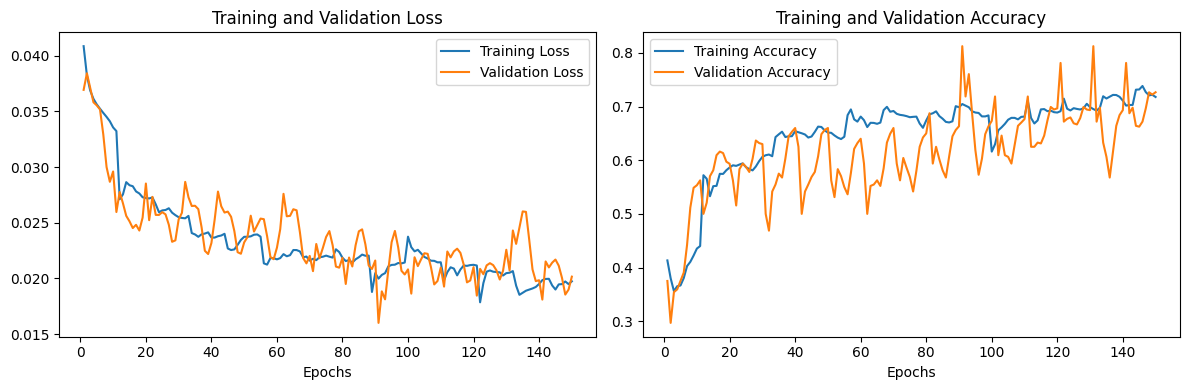

In [55]:
#instantiate TrainCurvePlotter with saved training history
plotter = TrainCurvePlotter('training_history_model1.pkl')

#load training history
plotter.load_training_history()

#plot training curves
plotter.plot()

**Make Predictions**

In [ ]:
#instantiate ModelPredictor
predictor = ModelPredictor(model1, val_loader, device)

#predict the class labels of all the images test loader
predictions, true_labels = predictor.predict()

#display predictions
print(f"Model One- Predictions: \n{predictions}")

#print the accuracy of the model on the val dataset
accuracy = (predictions == true_labels).mean()
print(f"\nModel One - Validation Accuracy: {accuracy * 100:.2f}%")

Model One- Predictions: 
[1 1 0 0 2 0 0 0 0 0 0 0 2 0 1 0 0 0 0 2 0 0 2 0 1 1 0 1 2 0 0 0 2 0 0 0 1
 0 0 0 0 0 0 0 2 0 2 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 2 0 0 1 1 1 1 1 0 0 0 0 1 1
 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 2 1 0 1 1 1 1 1 0 2 0 1 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 0 2 2 0 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]

Model One - Validation Accuracy: 78.33%


## **Model Two** -

Using Transfer Learning From Alex Net Pretrained Model

**Build Model**

In [33]:
class AlexNetPretrained(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNetPretrained, self).__init__()
        self.alexnet = alexnet(pretrained=True)
        #modify the classifier (last layer) for your number of classes
        self.alexnet.classifier[6] = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.alexnet(x)
        return x

**Get Summary**

In [43]:
#model summary
model2 = AlexNetPretrained()

#instantiate model summary class
model_summary = ModelSummary(model2)

#display model summary
print(model_summary)

AlexNetPretrained(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=Fals

**Train Model**

In [46]:
#set seed before training
set_seed(seed=36)

#train model two
#initialize model
model2 = AlexNetPretrained()

#set parameters
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.0001}

#instantiate optimizer
optimizer_instance = optimizer(model2.parameters(), **optimizer_params)

#instantiate trainer
trainer = Trainer(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=num_epochs,
    model_name='model2',
    verbose=True
)

#train model
trainer.train()

Epoch [1/20], Batch [66/66], Training Loss: 0.0103, Training Accuracy: 86.86%: 100%|██████████| 66/66 [00:47<00:00,  1.39it/s]
Epoch [1/20], Batch [10/10], Validation Loss: 0.0044, Validation Accuracy: 95.00%: 100%|██████████| 10/10 [00:01<00:00,  5.73it/s]
Epoch [2/20], Batch [66/66], Training Loss: 0.0050, Training Accuracy: 94.24%: 100%|██████████| 66/66 [00:46<00:00,  1.41it/s]
Epoch [2/20], Batch [10/10], Validation Loss: 0.0033, Validation Accuracy: 95.00%: 100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
Epoch [3/20], Batch [66/66], Training Loss: 0.0049, Training Accuracy: 93.95%: 100%|██████████| 66/66 [00:51<00:00,  1.29it/s]
Epoch [3/20], Batch [10/10], Validation Loss: 0.0032, Validation Accuracy: 96.00%: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
Epoch [4/20], Batch [66/66], Training Loss: 0.0030, Training Accuracy: 96.48%: 100%|██████████| 66/66 [00:47<00:00,  1.39it/s]
Epoch [4/20], Batch [10/10], Validation Loss: 0.0061, Validation Accuracy: 93.67%: 100%|██████████|

Early stopping triggered. No improvement for 5 epochs.

Training completed!
Training took 0 hours, 5 minutes, 43 seconds

Model saved at model2.pth


In [48]:
#save training history for model 2
history2 = {
    'train_loss_history': trainer.train_loss_history,
    'val_loss_history': trainer.val_loss_history,
    'train_acc_history': trainer.train_acc_history,
    'val_acc_history': trainer.val_acc_history,
}
save_training_history(history2, 'training_history_model2.pkl')

**Plot Training Curves**

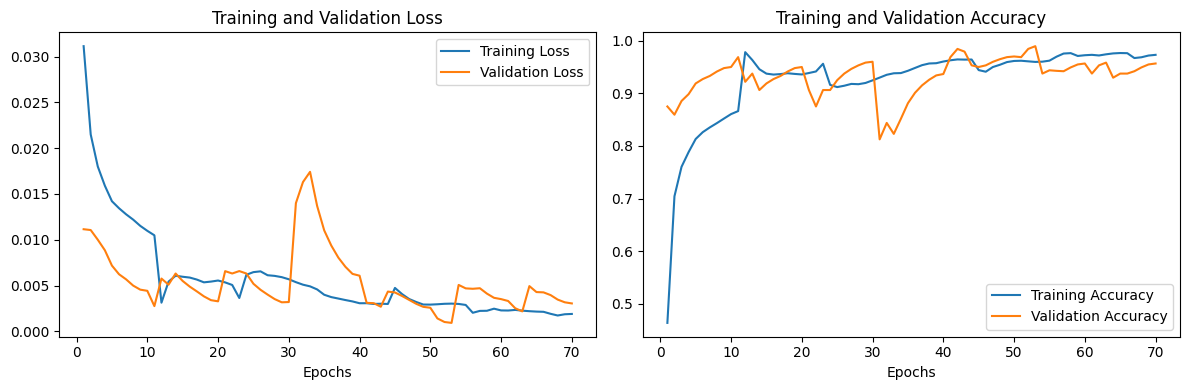

In [49]:
#instantiate TrainCurvePlotter with saved training history
plotter = TrainCurvePlotter('training_history_model2.pkl')

#load training history
plotter.load_training_history()

#plot training curves
plotter.plot()

**Make Predictions**

In [50]:
#instantiate ModelPredictor
predictor = ModelPredictor(model2, val_loader2, device)

#predict the class labels of all the images test loader
predictions, true_labels = predictor.predict()

#display predictions
print(f"Model Two- Predictions: \n{predictions}")

#print the accuracy of the model on the val dataset
accuracy = (predictions == true_labels).mean()
print(f"\nModel Two - Validation Accuracy: {accuracy * 100:.2f}%")

Model Two- Predictions: 
[0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]

Model Two - Validation Accuracy: 93.33%


## **Model Three** -

Using Transfer Learning From VGG Net Pretrained Model

**Build Model**

In [ ]:
class VGG16Pretrained(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16Pretrained, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        #modify the classifier (last layer) to fit number of classes
        num_ftrs = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.vgg16(x)
        return x

**Get Summary**

In [ ]:
#model summary
model3 = VGG16Pretrained()

#instantiate model summary class
model_summary = ModelSummary(model3)

#display model summary
print(model_summary)

**Train Model**

In [ ]:
#set seed before training
set_seed(seed=36)

#train model two
#initialize model
model2 = AlexNetPretrained()

#set parameters
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.0001}

#instantiate optimizer
optimizer_instance = optimizer(model2.parameters(), **optimizer_params)

#instantiate trainer
trainer = Trainer(
    model=model2,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=nn.CrossEntropyLoss().to(device),
    optimizer=optimizer_instance,
    device=device,
    num_epochs=num_epochs,
    model_name='model2',
    verbose=True
)

#train model
trainer.train()

**Plot training Curves**